🎵 ROODIO SINGLE SONG ANALYSIS
🔧 Loading trained models...
✅ Models loaded successfully!
   Features: 16

🎹 CHOOSE TESTING OPTION:
1. Test with your own audio file
2. Test with random song from dataset
3. Exit

🎤 ROODIO SINGLE SONG TESTER

🎵 Analyzing: Imagine Dragons - Thunder.mp3

🎯 ANALYSIS RESULTS:
📁 File: Imagine Dragons - Thunder.mp3
💖 Valence: 0.478 (emotional positiveness)
⚡ Arousal: 0.372 (emotional intensity)
🎭 Basic Mood: Sad/Calm
🔍 Detailed Mood: Neutral/Balanced
📍 Quadrant: Q3


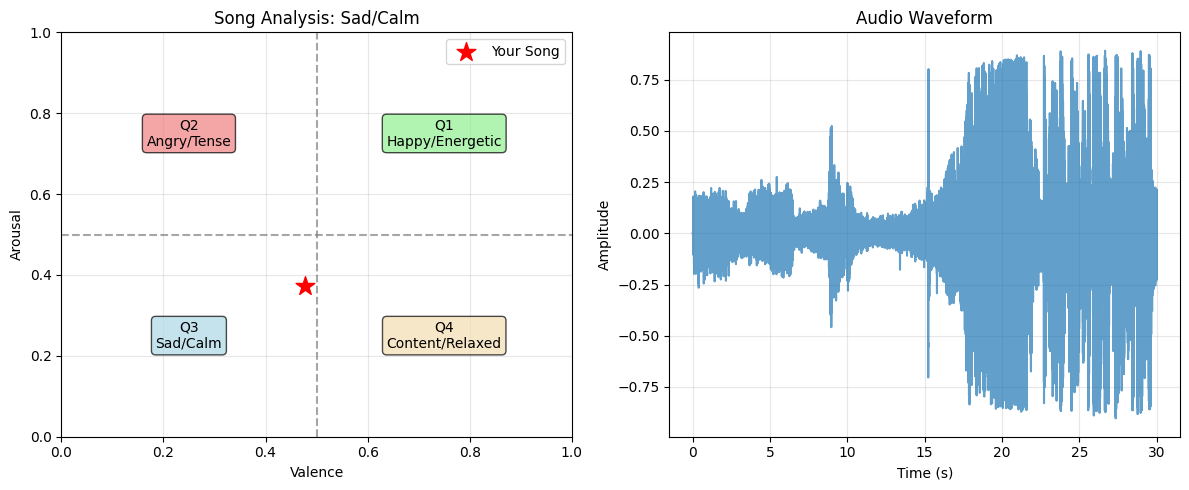


🔧 KEY AUDIO FEATURES:
   Tempo (BPM): 161.4990
   Spectral Centroid: 1493.6266
   Spectral Rolloff: 3123.5644
   MFCC 1 (Brightness): -159.5365
   RMS Energy: 0.1420
   Zero Crossing Rate: 0.0558

🎵 SIMILAR SONGS RECOMMENDATIONS:
   1. MT0012666474 - Sad/Calm (V:0.48, A:0.37)
   2. MT0000446304 - Sad/Calm (V:0.48, A:0.37)
   3. MT0003129858 - Sad/Calm (V:0.48, A:0.36)

💾 Analysis saved to: song_analysis_Imagine Dragons - Thunder.csv

🎉 ROODIO SINGLE SONG ANALYSIS READY!
You can now analyze any MP3 file and get mood predictions!


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
import librosa
import librosa.display
import os
import glob
import warnings
import joblib

warnings.filterwarnings('ignore')

# Define missing functions that are used in the code
def extract_audio_features(audio_path, duration=30):
    """Extract comprehensive audio features from MP3 file"""
    try:
        # Load audio file (first 30 seconds for efficiency)
        y, sr = librosa.load(audio_path, duration=duration, sr=22050)
        
        features = {}
        
        # Basic features
        features['duration'] = len(y) / sr
        features['sr'] = sr
        
        # Temporal features
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = float(tempo)  # Convert to float
        
        # Spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
        features['spectral_centroid_mean'] = float(np.mean(spectral_centroids))
        features['spectral_centroid_std'] = float(np.std(spectral_centroids))
        
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        features['spectral_rolloff_mean'] = float(np.mean(spectral_rolloff))
        
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        features['spectral_bandwidth_mean'] = float(np.mean(spectral_bandwidth))
        
        # MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc_{i+1}_mean'] = float(np.mean(mfccs[i]))
            features[f'mfcc_{i+1}_std'] = float(np.std(mfccs[i]))
        
        # Chroma features
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        features['chroma_stft_mean'] = float(np.mean(chroma_stft))
        features['chroma_stft_std'] = float(np.std(chroma_stft))
        
        # RMS
        rms = librosa.feature.rms(y=y)
        features['rms_mean'] = float(np.mean(rms))
        features['rms_std'] = float(np.std(rms))
        
        # Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(y)
        features['zcr_mean'] = float(np.mean(zcr))
        features['zcr_std'] = float(np.std(zcr))
        
        # Harmonic and percussive
        y_harmonic, y_percussive = librosa.effects.hpss(y)
        features['harmonic_mean'] = float(np.mean(y_harmonic))
        features['percussive_mean'] = float(np.mean(y_percussive))
        
        # Spectral contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features['spectral_contrast_mean'] = float(np.mean(spectral_contrast))
        
        return features, y, sr
        
    except Exception as e:
        print(f"❌ Error processing {audio_path}: {e}")
        return None, None, None

def classify_mood(valence, arousal):
    """Classify mood based on Valence-Arousal coordinates"""
    if valence >= 0.5 and arousal >= 0.5:
        return "Happy/Energetic"
    elif valence < 0.5 and arousal >= 0.5:
        return "Angry/Tense" 
    elif valence < 0.5 and arousal < 0.5:
        return "Sad/Calm"
    else:
        return "Content/Relaxed"

def classify_mood_detailed(valence, arousal):
    """More detailed mood classification"""
    if valence >= 0.7 and arousal >= 0.7:
        return "Excited/Euphoric"
    elif valence >= 0.6 and arousal >= 0.6:
        return "Happy/Energetic"
    elif valence >= 0.5 and arousal >= 0.5:
        return "Content/Active"
    elif valence < 0.3 and arousal >= 0.7:
        return "Angry/Stressed"
    elif valence < 0.4 and arousal >= 0.6:
        return "Tense/Anxious"
    elif valence < 0.3 and arousal < 0.3:
        return "Sad/Depressed"
    elif valence < 0.4 and arousal < 0.4:
        return "Melancholy/Calm"
    elif valence >= 0.7 and arousal < 0.3:
        return "Peaceful/Relaxed"
    elif valence >= 0.6 and arousal < 0.4:
        return "Content/Serene"
    else:
        return "Neutral/Balanced"

def pred_to_quadrant(valence, arousal):
    """Map valence-arousal to quadrant"""
    if valence >= 0.5 and arousal >= 0.5:
        return 'Q1'
    elif valence < 0.5 and arousal >= 0.5:
        return 'Q2'
    elif valence < 0.5 and arousal < 0.5:
        return 'Q3'
    else:
        return 'Q4'

# Define QUADRANT_MAPPING
QUADRANT_MAPPING = {
    'Q1': {'name': 'Happy/Energetic', 'valence': 'high', 'arousal': 'high'},
    'Q2': {'name': 'Angry/Tense', 'valence': 'low', 'arousal': 'high'},
    'Q3': {'name': 'Sad/Calm', 'valence': 'low', 'arousal': 'low'},
    'Q4': {'name': 'Content/Relaxed', 'valence': 'high', 'arousal': 'low'}
}

# TESTING CODE: Analyze Single Song
print("🎵 ROODIO SINGLE SONG ANALYSIS")
print("="*50)

# Load the trained models and components
print("🔧 Loading trained models...")

try:
    # Load all components
    arousal_model = joblib.load('roodio_arousal_model_final.pkl')
    valence_model = joblib.load('roodio_valence_model_final.pkl') 
    scaler = joblib.load('roodio_scaler_final.pkl')
    feature_names = joblib.load('roodio_features_final.pkl')
    
    print("✅ Models loaded successfully!")
    print(f"   Features: {len(feature_names)}")
    
except Exception as e:
    print(f"❌ Error loading models: {e}")
    print("Please make sure the model files exist in the current directory")

# Function to analyze a single song
def analyze_single_song(audio_path):
    """Analyze a single song and return mood prediction"""
    print(f"\n🎵 Analyzing: {os.path.basename(audio_path)}")
    
    # Extract features
    features, audio_data, sr = extract_audio_features(audio_path)
    if features is None:
        print("❌ Failed to extract audio features")
        return None, None, None, None
    
    # Prepare features for prediction
    feature_vector = []
    for feature_name in feature_names:
        if feature_name in features:
            feature_vector.append(features[feature_name])
        else:
            print(f"⚠️  Missing feature: {feature_name}")
            feature_vector.append(0.0)
    
    # Scale features
    features_array = np.array(feature_vector).reshape(1, -1)
    features_scaled = scaler.transform(features_array)
    
    # Predict valence and arousal
    valence = valence_model.predict(features_scaled)[0]
    arousal = arousal_model.predict(features_scaled)[0]
    
    # Clip to valid range
    valence = np.clip(valence, 0, 1)
    arousal = np.clip(arousal, 0, 1)
    
    # Classify mood
    mood_basic = classify_mood(valence, arousal)
    mood_detailed = classify_mood_detailed(valence, arousal)
    
    # Create result
    result = {
        'filename': os.path.basename(audio_path),
        'valence': valence,
        'arousal': arousal,
        'mood_basic': mood_basic,
        'mood_detailed': mood_detailed,
        'valence_arousal': (valence, arousal),
        'quadrant': pred_to_quadrant(valence, arousal)
    }
    
    return result, features, audio_data, sr

# Function to display analysis results
def display_song_analysis(result, features=None, audio_data=None, sr=None):
    """Display detailed analysis results"""
    print(f"\n🎯 ANALYSIS RESULTS:")
    print("="*40)
    print(f"📁 File: {result['filename']}")
    print(f"💖 Valence: {result['valence']:.3f} (emotional positiveness)")
    print(f"⚡ Arousal: {result['arousal']:.3f} (emotional intensity)")
    print(f"🎭 Basic Mood: {result['mood_basic']}")
    print(f"🔍 Detailed Mood: {result['mood_detailed']}")
    print(f"📍 Quadrant: {result['quadrant']}")
    
    # Visualize in Valence-Arousal space
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Single song in V-A space
    plt.subplot(1, 2, 1)
    
    # Plot quadrant boundaries
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
    plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
    
    # Plot the song
    plt.scatter(result['valence'], result['arousal'], c='red', s=200, marker='*', label='Your Song')
    
    # Add quadrant labels
    plt.text(0.75, 0.75, 'Q1\nHappy/Energetic', ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))
    plt.text(0.25, 0.75, 'Q2\nAngry/Tense', ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.7))
    plt.text(0.25, 0.25, 'Q3\nSad/Calm', ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))
    plt.text(0.75, 0.25, 'Q4\nContent/Relaxed', ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='wheat', alpha=0.7))
    
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.title(f'Song Analysis: {result["mood_basic"]}')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: Audio visualization (if audio data available)
    if audio_data is not None and sr is not None:
        plt.subplot(1, 2, 2)
        
        # Plot waveform
        plt.plot(np.linspace(0, len(audio_data)/sr, len(audio_data)), audio_data, alpha=0.7)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('Audio Waveform')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display key features - FIXED: Convert to float before formatting
    if features:
        print(f"\n🔧 KEY AUDIO FEATURES:")
        important_features = {
            'tempo': 'Tempo (BPM)',
            'spectral_centroid_mean': 'Spectral Centroid',
            'spectral_rolloff_mean': 'Spectral Rolloff', 
            'mfcc_1_mean': 'MFCC 1 (Brightness)',
            'rms_mean': 'RMS Energy',
            'zcr_mean': 'Zero Crossing Rate'
        }
        
        for feature, description in important_features.items():
            if feature in features:
                # Convert to float to ensure proper formatting
                value = float(features[feature])
                print(f"   {description}: {value:.4f}")

# Function to get song recommendations based on analysis
def get_song_recommendations(target_valence, target_arousal, n_recommendations=3):
    """Get song recommendations based on emotional similarity"""
    try:
        # Load the full database
        database = pd.read_csv('roodio_final_database.csv')
        
        # Calculate emotional distance
        database['emotion_distance'] = np.sqrt(
            (database['valence_pred'] - target_valence)**2 + 
            (database['arousal_pred'] - target_arousal)**2
        )
        
        # Get closest matches (excluding exact matches)
        recommendations = database.nsmallest(n_recommendations + 5, 'emotion_distance')
        recommendations = recommendations.head(n_recommendations)
        
        return recommendations
    except Exception as e:
        print(f"❌ Error getting recommendations: {e}")
        return None

# MAIN TESTING INTERFACE
def test_single_song():
    """Main function to test a single song"""
    print("\n🎤 ROODIO SINGLE SONG TESTER")
    print("="*40)
    
    # Get audio file path from user
    audio_path = input("Enter the path to your audio file: ").strip().strip('"')
    
    if not os.path.exists(audio_path):
        print("❌ File not found! Please check the path.")
        return
    
    # Analyze the song
    result, features, audio_data, sr = analyze_single_song(audio_path)
    
    if result:
        # Display results
        display_song_analysis(result, features, audio_data, sr)
        
        # Get recommendations
        print(f"\n🎵 SIMILAR SONGS RECOMMENDATIONS:")
        recommendations = get_song_recommendations(result['valence'], result['arousal'])
        
        if recommendations is not None and len(recommendations) > 0:
            for i, (_, song) in enumerate(recommendations.iterrows()):
                print(f"   {i+1}. {song['song_id']} - {song['mood_basic_pred']} "
                      f"(V:{song['valence_pred']:.2f}, A:{song['arousal_pred']:.2f})")
        else:
            print("   No recommendations available")
        
        # Save individual result
        result_df = pd.DataFrame([result])
        filename_base = os.path.splitext(result['filename'])[0]
        result_df.to_csv(f'song_analysis_{filename_base}.csv', index=False)
        print(f"\n💾 Analysis saved to: song_analysis_{filename_base}.csv")
        
    else:
        print("❌ Failed to analyze the song")

# Alternative: Test with a file from the dataset (for quick testing)
def test_with_dataset_song():
    """Test with a random song from the dataset"""
    print("\n🎲 TESTING WITH RANDOM DATASET SONG")
    
    # Get a random song from the dataset
    base_path = "../../data/MERGE_Audio_Complete"
    all_quadrants = ['Q1', 'Q2', 'Q3', 'Q4']
    random_quadrant = np.random.choice(all_quadrants)
    
    quadrant_path = os.path.join(base_path, random_quadrant)
    mp3_files = glob.glob(os.path.join(quadrant_path, "*.mp3"))
    
    if mp3_files:
        test_song = np.random.choice(mp3_files)
        print(f"Testing with: {os.path.basename(test_song)} from {random_quadrant}")
        
        result, features, audio_data, sr = analyze_single_song(test_song)
        if result:
            display_song_analysis(result, features, audio_data, sr)
    else:
        print("❌ No audio files found in dataset")

# RUN THE TESTER
print("\n🎹 CHOOSE TESTING OPTION:")
print("1. Test with your own audio file")
print("2. Test with random song from dataset")
print("3. Exit")

choice = input("Enter your choice (1-3): ").strip()

if choice == '1':
    test_single_song()
elif choice == '2':
    test_with_dataset_song()
elif choice == '3':
    print("👋 Goodbye!")
else:
    print("❌ Invalid choice!")

print(f"\n🎉 ROODIO SINGLE SONG ANALYSIS READY!")
print("You can now analyze any MP3 file and get mood predictions!")

🎵 ROODIO SINGLE SONG ANALYSIS - FULL DURATION
🔧 Loading trained models...
✅ Models loaded successfully!
   Features: 16

🎹 CHOOSE TESTING OPTION:
1. Test with your own audio file (FULL DURATION)
2. Exit

🎤 ROODIO SINGLE SONG TESTER - FULL DURATION
⚠️  NOTE: This will analyze the ENTIRE song (may take longer)

🎵 Analyzing FULL DURATION: Virgoun - Surat Cinta Untuk Starla (Official Lyric Video).mp3
   ✅ Processed full song: 273.3 seconds

🎯 ANALYSIS RESULTS (FULL DURATION):
📁 File: Virgoun - Surat Cinta Untuk Starla (Official Lyric Video).mp3
⏱️  Duration: 273.3 seconds
💖 Valence: 0.642 (emotional positiveness)
⚡ Arousal: 0.382 (emotional intensity)
🎭 Basic Mood: Content/Relaxed
🔍 Detailed Mood: Content/Serene
📍 Quadrant: Q4


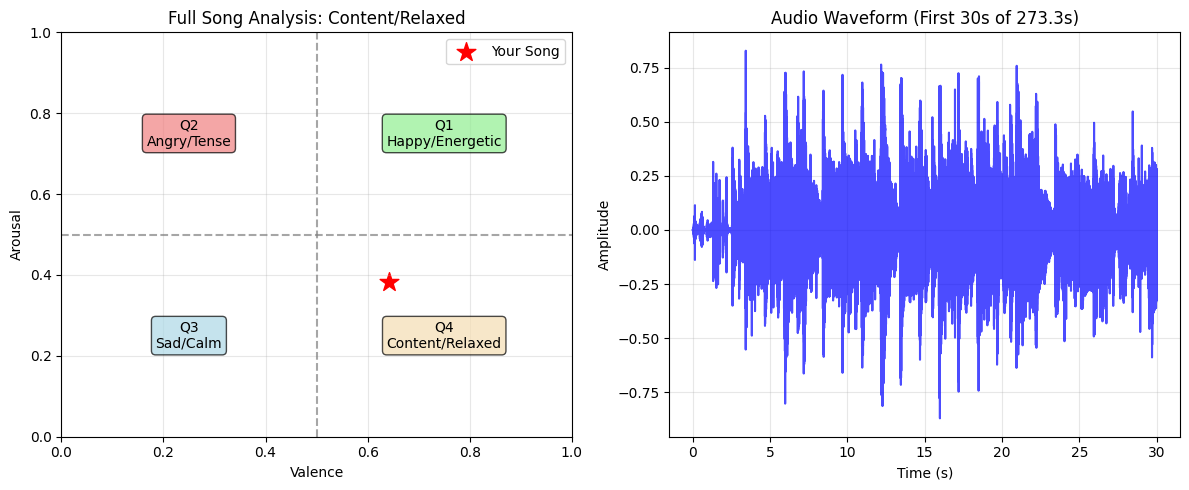


🔧 KEY AUDIO FEATURES (FULL SONG):
   Tempo (BPM): 143.5547
   Duration (seconds): 273.3
   Spectral Centroid: 2090.7612
   Spectral Rolloff: 4714.5504
   MFCC 1 (Brightness): -95.1518
   RMS Energy: 0.2030
   Zero Crossing Rate: 0.0767
   Beat Count: 653.0000

🎵 SIMILAR SONGS RECOMMENDATIONS:
   1. MT0007039041 - Content/Relaxed (V:0.64, A:0.38)
   2. MT0033818006 - Content/Relaxed (V:0.64, A:0.38)
   3. MT0012924767 - Content/Relaxed (V:0.64, A:0.38)

💾 Full analysis saved to: song_analysis_full_Virgoun - Surat Cinta Untuk Starla (Official Lyric Video).csv

🎉 ROODIO FULL DURATION ANALYSIS READY!
Now analyzing COMPLETE songs instead of just 30-second samples!


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
import librosa
import librosa.display
import os
import glob
import warnings
import joblib

warnings.filterwarnings('ignore')

# Define audio feature extraction function for FULL DURATION
def extract_audio_features_full_duration(audio_path, duration=None):
    """Extract comprehensive audio features from FULL MP3 file"""
    try:
        # Load audio file - FULL DURATION (remove duration parameter)
        y, sr = librosa.load(audio_path, sr=22050)  # No duration limit
        
        features = {}
        
        # Basic features
        features['duration'] = len(y) / sr
        features['sr'] = sr
        
        # Temporal features - for full song
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = float(tempo)
        features['beat_count'] = len(beats)
        
        # Spectral features - for full song
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
        features['spectral_centroid_mean'] = float(np.mean(spectral_centroids))
        features['spectral_centroid_std'] = float(np.std(spectral_centroids))
        
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        features['spectral_rolloff_mean'] = float(np.mean(spectral_rolloff))
        
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        features['spectral_bandwidth_mean'] = float(np.mean(spectral_bandwidth))
        
        # MFCCs - for full song
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc_{i+1}_mean'] = float(np.mean(mfccs[i]))
            features[f'mfcc_{i+1}_std'] = float(np.std(mfccs[i]))
        
        # Chroma features - for full song
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        features['chroma_stft_mean'] = float(np.mean(chroma_stft))
        features['chroma_stft_std'] = float(np.std(chroma_stft))
        
        # RMS - for full song
        rms = librosa.feature.rms(y=y)
        features['rms_mean'] = float(np.mean(rms))
        features['rms_std'] = float(np.std(rms))
        
        # Zero crossing rate - for full song
        zcr = librosa.feature.zero_crossing_rate(y)
        features['zcr_mean'] = float(np.mean(zcr))
        features['zcr_std'] = float(np.std(zcr))
        
        # Harmonic and percussive - for full song
        y_harmonic, y_percussive = librosa.effects.hpss(y)
        features['harmonic_mean'] = float(np.mean(y_harmonic))
        features['percussive_mean'] = float(np.mean(y_percussive))
        
        # Spectral contrast - for full song
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features['spectral_contrast_mean'] = float(np.mean(spectral_contrast))
        
        print(f"   ✅ Processed full song: {features['duration']:.1f} seconds")
        return features, y, sr
        
    except Exception as e:
        print(f"❌ Error processing {audio_path}: {e}")
        return None, None, None

def classify_mood(valence, arousal):
    """Classify mood based on Valence-Arousal coordinates"""
    if valence >= 0.5 and arousal >= 0.5:
        return "Happy/Energetic"
    elif valence < 0.5 and arousal >= 0.5:
        return "Angry/Tense" 
    elif valence < 0.5 and arousal < 0.5:
        return "Sad/Calm"
    else:
        return "Content/Relaxed"

def classify_mood_detailed(valence, arousal):
    """More detailed mood classification"""
    if valence >= 0.7 and arousal >= 0.7:
        return "Excited/Euphoric"
    elif valence >= 0.6 and arousal >= 0.6:
        return "Happy/Energetic"
    elif valence >= 0.5 and arousal >= 0.5:
        return "Content/Active"
    elif valence < 0.3 and arousal >= 0.7:
        return "Angry/Stressed"
    elif valence < 0.4 and arousal >= 0.6:
        return "Tense/Anxious"
    elif valence < 0.3 and arousal < 0.3:
        return "Sad/Depressed"
    elif valence < 0.4 and arousal < 0.4:
        return "Melancholy/Calm"
    elif valence >= 0.7 and arousal < 0.3:
        return "Peaceful/Relaxed"
    elif valence >= 0.6 and arousal < 0.4:
        return "Content/Serene"
    else:
        return "Neutral/Balanced"

def pred_to_quadrant(valence, arousal):
    """Map valence-arousal to quadrant"""
    if valence >= 0.5 and arousal >= 0.5:
        return 'Q1'
    elif valence < 0.5 and arousal >= 0.5:
        return 'Q2'
    elif valence < 0.5 and arousal < 0.5:
        return 'Q3'
    else:
        return 'Q4'

# Define QUADRANT_MAPPING
QUADRANT_MAPPING = {
    'Q1': {'name': 'Happy/Energetic', 'valence': 'high', 'arousal': 'high'},
    'Q2': {'name': 'Angry/Tense', 'valence': 'low', 'arousal': 'high'},
    'Q3': {'name': 'Sad/Calm', 'valence': 'low', 'arousal': 'low'},
    'Q4': {'name': 'Content/Relaxed', 'valence': 'high', 'arousal': 'low'}
}

# TESTING CODE: Analyze Single Song with FULL DURATION
print("🎵 ROODIO SINGLE SONG ANALYSIS - FULL DURATION")
print("="*60)

# Load the trained models and components
print("🔧 Loading trained models...")

try:
    # Load all components
    arousal_model = joblib.load('roodio_arousal_model_final.pkl')
    valence_model = joblib.load('roodio_valence_model_final.pkl') 
    scaler = joblib.load('roodio_scaler_final.pkl')
    feature_names = joblib.load('roodio_features_final.pkl')
    
    print("✅ Models loaded successfully!")
    print(f"   Features: {len(feature_names)}")
    
except Exception as e:
    print(f"❌ Error loading models: {e}")
    print("Please make sure the model files exist in the current directory")

# Function to analyze a single song with FULL DURATION
def analyze_single_song_full_duration(audio_path):
    """Analyze a single song (FULL DURATION) and return mood prediction"""
    print(f"\n🎵 Analyzing FULL DURATION: {os.path.basename(audio_path)}")
    
    # Extract features from FULL song
    features, audio_data, sr = extract_audio_features_full_duration(audio_path)
    if features is None:
        print("❌ Failed to extract audio features")
        return None, None, None, None
    
    # Prepare features for prediction
    feature_vector = []
    for feature_name in feature_names:
        if feature_name in features:
            feature_vector.append(features[feature_name])
        else:
            print(f"⚠️  Missing feature: {feature_name}")
            feature_vector.append(0.0)
    
    # Scale features
    features_array = np.array(feature_vector).reshape(1, -1)
    features_scaled = scaler.transform(features_array)
    
    # Predict valence and arousal
    valence = valence_model.predict(features_scaled)[0]
    arousal = arousal_model.predict(features_scaled)[0]
    
    # Clip to valid range
    valence = np.clip(valence, 0, 1)
    arousal = np.clip(arousal, 0, 1)
    
    # Classify mood
    mood_basic = classify_mood(valence, arousal)
    mood_detailed = classify_mood_detailed(valence, arousal)
    
    # Create result
    result = {
        'filename': os.path.basename(audio_path),
        'duration_seconds': features['duration'],
        'valence': valence,
        'arousal': arousal,
        'mood_basic': mood_basic,
        'mood_detailed': mood_detailed,
        'valence_arousal': (valence, arousal),
        'quadrant': pred_to_quadrant(valence, arousal)
    }
    
    return result, features, audio_data, sr

# Function to display analysis results
def display_song_analysis_full_duration(result, features=None, audio_data=None, sr=None):
    """Display detailed analysis results for FULL DURATION"""
    print(f"\n🎯 ANALYSIS RESULTS (FULL DURATION):")
    print("="*50)
    print(f"📁 File: {result['filename']}")
    print(f"⏱️  Duration: {result['duration_seconds']:.1f} seconds")
    print(f"💖 Valence: {result['valence']:.3f} (emotional positiveness)")
    print(f"⚡ Arousal: {result['arousal']:.3f} (emotional intensity)")
    print(f"🎭 Basic Mood: {result['mood_basic']}")
    print(f"🔍 Detailed Mood: {result['mood_detailed']}")
    print(f"📍 Quadrant: {result['quadrant']}")
    
    # Visualize in Valence-Arousal space
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Single song in V-A space
    plt.subplot(1, 2, 1)
    
    # Plot quadrant boundaries
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
    plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
    
    # Plot the song
    plt.scatter(result['valence'], result['arousal'], c='red', s=200, marker='*', label='Your Song')
    
    # Add quadrant labels
    plt.text(0.75, 0.75, 'Q1\nHappy/Energetic', ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))
    plt.text(0.25, 0.75, 'Q2\nAngry/Tense', ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.7))
    plt.text(0.25, 0.25, 'Q3\nSad/Calm', ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7))
    plt.text(0.75, 0.25, 'Q4\nContent/Relaxed', ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='wheat', alpha=0.7))
    
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.title(f'Full Song Analysis: {result["mood_basic"]}')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: Audio waveform (first 30 seconds for visualization)
    if audio_data is not None and sr is not None:
        plt.subplot(1, 2, 2)
        
        # Show only first 30 seconds for clean visualization
        max_display_samples = min(30 * sr, len(audio_data))
        display_audio = audio_data[:max_display_samples]
        
        plt.plot(np.linspace(0, len(display_audio)/sr, len(display_audio)), 
                display_audio, alpha=0.7, color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title(f'Audio Waveform (First 30s of {result["duration_seconds"]:.1f}s)')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display key features
    if features:
        print(f"\n🔧 KEY AUDIO FEATURES (FULL SONG):")
        important_features = {
            'tempo': 'Tempo (BPM)',
            'duration': 'Duration (seconds)',
            'spectral_centroid_mean': 'Spectral Centroid',
            'spectral_rolloff_mean': 'Spectral Rolloff', 
            'mfcc_1_mean': 'MFCC 1 (Brightness)',
            'rms_mean': 'RMS Energy',
            'zcr_mean': 'Zero Crossing Rate',
            'beat_count': 'Beat Count'
        }
        
        for feature, description in important_features.items():
            if feature in features:
                value = float(features[feature])
                if feature == 'duration':
                    print(f"   {description}: {value:.1f}")
                else:
                    print(f"   {description}: {value:.4f}")

# Function to get song recommendations based on analysis
def get_song_recommendations(target_valence, target_arousal, n_recommendations=3):
    """Get song recommendations based on emotional similarity"""
    try:
        # Load the full database
        database = pd.read_csv('roodio_final_database.csv')
        
        # Calculate emotional distance
        database['emotion_distance'] = np.sqrt(
            (database['valence_pred'] - target_valence)**2 + 
            (database['arousal_pred'] - target_arousal)**2
        )
        
        # Get closest matches
        recommendations = database.nsmallest(n_recommendations + 5, 'emotion_distance')
        recommendations = recommendations.head(n_recommendations)
        
        return recommendations
    except Exception as e:
        print(f"❌ Error getting recommendations: {e}")
        return None

# MAIN TESTING INTERFACE - FULL DURATION
def test_single_song_full_duration():
    """Main function to test a single song with FULL DURATION"""
    print("\n🎤 ROODIO SINGLE SONG TESTER - FULL DURATION")
    print("="*50)
    print("⚠️  NOTE: This will analyze the ENTIRE song (may take longer)")
    
    # Get audio file path from user
    audio_path = input("Enter the path to your audio file: ").strip().strip('"')
    
    if not os.path.exists(audio_path):
        print("❌ File not found! Please check the path.")
        return
    
    # Analyze the song with FULL DURATION
    result, features, audio_data, sr = analyze_single_song_full_duration(audio_path)
    
    if result:
        # Display results
        display_song_analysis_full_duration(result, features, audio_data, sr)
        
        # Get recommendations
        print(f"\n🎵 SIMILAR SONGS RECOMMENDATIONS:")
        recommendations = get_song_recommendations(result['valence'], result['arousal'])
        
        if recommendations is not None and len(recommendations) > 0:
            for i, (_, song) in enumerate(recommendations.iterrows()):
                print(f"   {i+1}. {song['song_id']} - {song['mood_basic_pred']} "
                      f"(V:{song['valence_pred']:.2f}, A:{song['arousal_pred']:.2f})")
        else:
            print("   No recommendations available")
        
        # Save individual result
        result_df = pd.DataFrame([result])
        filename_base = os.path.splitext(result['filename'])[0]
        result_df.to_csv(f'song_analysis_full_{filename_base}.csv', index=False)
        print(f"\n💾 Full analysis saved to: song_analysis_full_{filename_base}.csv")
        
    else:
        print("❌ Failed to analyze the song")

# RUN THE TESTER
print("\n🎹 CHOOSE TESTING OPTION:")
print("1. Test with your own audio file (FULL DURATION)")
print("2. Exit")

choice = input("Enter your choice (1-2): ").strip()

if choice == '1':
    test_single_song_full_duration()
elif choice == '2':
    print("👋 Goodbye!")
else:
    print("❌ Invalid choice!")

print(f"\n🎉 ROODIO FULL DURATION ANALYSIS READY!")
print("Now analyzing COMPLETE songs instead of just 30-second samples!")